In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import optuna
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [4]:
df = pd.read_csv("fmnist_small.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


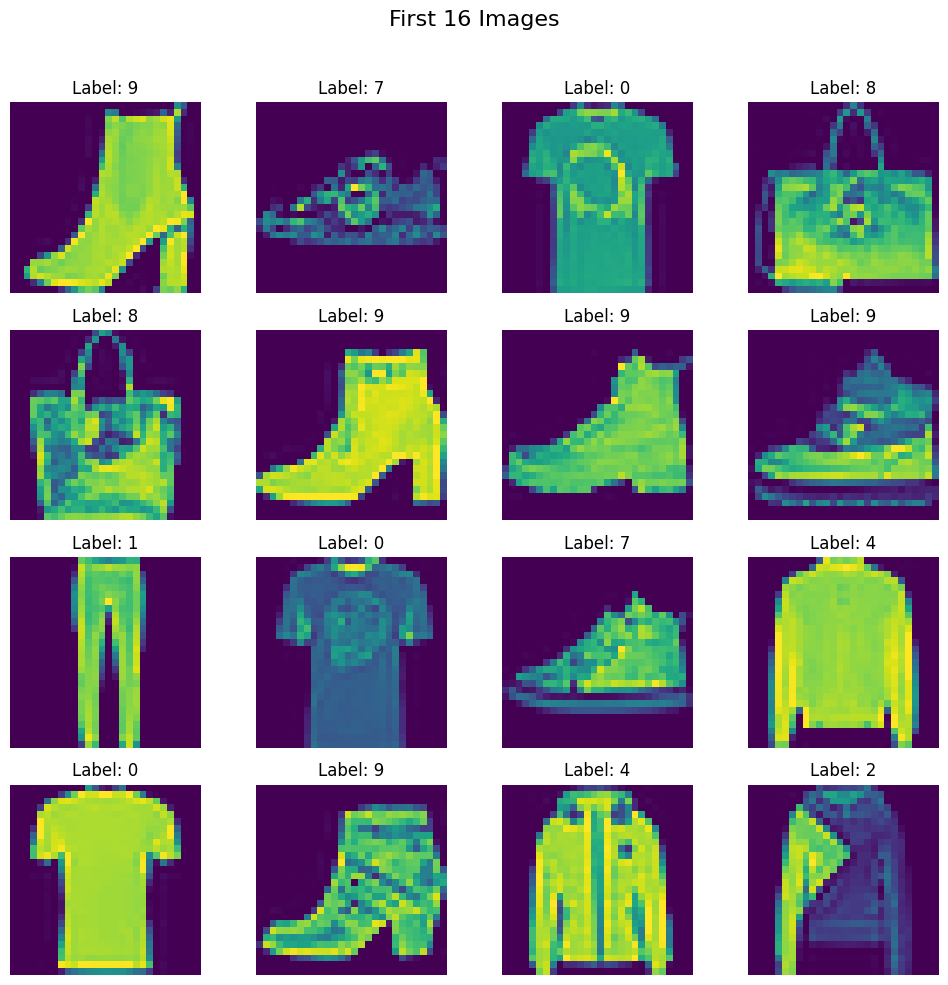

In [5]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [6]:
# seperate target andf input features
X = df.drop(columns = ['label'] , axis = 1)
y = df['label']

In [7]:
# do the train test split 
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# convert all these into numpy array 
X_train = X_train.to_numpy()
X_test = X_test.to_numpy() 
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [11]:
from torchvision import transforms

In [12]:
# train data with image augmentation
train_transform = transforms.Compose([
    # Convert the numpy array into Pillow image 
    transforms.ToPILImage(), 
    transforms.RandomRotation(degrees = 10), 
    transforms.RandomHorizontalFlip(p = 0.5), 
    transforms.RandomAffine(degrees = 0, translate = (0.1 , 0.1)), 
    transforms.ToTensor()
])

# test data with no image augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [13]:
class CustomDataset(Dataset): 
    def __init__(self , features , labels , transform = None):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self , index):
        feature , label = self.features[index] , self.labels[index]
        if self.transform:
           feature = self.transform(feature.squeeze(0).numpy())
        return feature , label 

In [14]:
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

In [15]:
class DynamicCNN(nn.Module): 
    def __init__(self, num_conv_layers, num_filters, kernel_size,num_fc_layers, fc_layer_size, dropout_rate):
        super(DynamicCNN , self).__init__()
        layers = [] # CNN layers
        in_channels = 1 # grayscale image

        # Convolutional layers
        for _ in range(num_conv_layers): 
            layers.append(
                nn.Conv2d(in_channels, num_filters, kernel_size = kernel_size, padding = 'same')
            )
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size = 2 , stride = 2))
            in_channels = num_filters # Update input channels for the next layer

        self.feature_extraction = nn.Sequential(*layers)

        # Fully connected layers
        fc_layers = []
        fc_layers.append(nn.Flatten())
        input_size = num_filters * (28 // (2**num_conv_layers)) ** 2
        for _ in range(num_fc_layers): 
            fc_layers.append(
                nn.Linear(input_size , fc_layer_size)
            )
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            input_size = fc_layer_size

        # FInally add the output layer
        fc_layers.append(nn.Linear(input_size , 10))
        self.classifier = nn.Sequential(*fc_layers)

    def forward(self , x):
        x = self.feature_extraction(x)
        x = self.classifier(x)
        return x 

In [16]:
# Define the objective function for Optuna 
def objective(trial): 
    # Hyperparameters to tune 
    num_conv_layers = trial.suggest_int('num_conv_layers' , 1 , 3)
    num_filters = trial.suggest_categorical('num_filters' , [16 , 32 , 64 , 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3 , 5])
    num_fc_layers = trial.suggest_int('num_fc_layers' , 1 , 3)
    fc_layer_size = trial.suggest_categorical('fc_layer_size', [64 , 128, 256])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2 , 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay' , 1e-5, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate' , 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 30)

    # Initialize the model 
    model = DynamicCNN(num_conv_layers, num_filters, kernel_size,num_fc_layers, fc_layer_size, dropout_rate)
    model.to(device)

    # Data 
    train_loader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True)
    test_loader = DataLoader(test_dataset , batch_size = batch_size)

    # Optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

    # Loss function 
    criterion = nn.CrossEntropyLoss()

    # Training loop 
    for epoch in range(num_epochs):
        model.train()
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    
    accuracy = correct / total
    return accuracy

In [17]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction = 'maximize' , pruner = pruner)
study.optimize(objective , n_trials = 100) 

[I 2026-01-11 21:11:12,784] A new study created in memory with name: no-name-5d3054a4-94c2-49ea-91fd-4f083164a8af
C:\Users\tipto\AppData\Local\Temp\ipykernel_20260\3044877278.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2 , 0.5)
C:\Users\tipto\AppData\Local\Temp\ipykernel_20260\3044877278.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay' , 1e-5, 1e-2)
C:\Users\tipto\AppData\Local\Temp\ipykernel_20260\3044877278.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

KeyboardInterrupt: 

In [18]:
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best hyperparameters: {'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 3, 'num_fc_layers': 2, 'fc_layer_size': 256, 'dropout_rate': 0.3503807139162048, 'weight_decay': 1.0857799762359268e-05, 'learning_rate': 0.0010175344452744877, 'optimizer': 'Adam', 'batch_size': 128, 'num_epochs': 29}
Best accuracy: 0.855
